In [1]:
import os # To check whether file exists
import json # To save GPS coordinates as a JSON file
from geopy.geocoders import Nominatim # To get districts' GPS coordinates
import numpy as np # Math stuff
from matplotlib import pyplot as plt # To plot histogram

In [10]:
# To compute distance between two (lat,long) coords on the globe (for those of us who believe the earth is round)
def haversine_distance(lat1, long1, lat2, long2):
    phi1 = (90.0 - lat1)*np.pi/180.0
    phi2 = (90.0 - lat2)*np.pi/180.0
    theta1 = long1*np.pi/180.0
    theta2 = long2*np.pi/180.0
    cos = min(1,np.sin(phi1)*np.sin(phi2)*np.cos(theta1 - theta2) + np.cos(phi1)*np.cos(phi2))
    arc = np.arccos(cos)
    return 6373*arc
#end

In [3]:
# Obtain district names
district_names = [x.strip() for x in open('bairros.txt','r').readlines()]

In [4]:
# Obtain geolocator
geolocator = Nominatim()

/home/marcelo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Using Nominatim with the default "geopy/1.19.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


In [8]:
# Save district locations to dict
if not os.path.isfile('district_locations.json'):
    district_locations = {}
    for district in district_names:
        location = geolocator.geocode(f'{district}, Porto Alegre')
        district_locations[district] = (location.latitude, location.longitude)
        print(f'{district} lat={location.latitude} lon={location.longitude}')
    #end
    json.dump(district_locations,open('district_locations.json','w'))
#end
district_locations = json.load(open('district_locations.json','r'))

In [11]:
# Compute dict mapping each district name to a list of (district,distance) tuples, sorted by distance
distances = { d1:sorted([ (d2,haversine_distance(*district_locations[d1],*district_locations[d2])) for d2 in district_names ], key=lambda x: x[1]) for d1 in district_names }

In [12]:
# Run a war simulation
def simulate():
    # Init map of occupations
    occupied_by = { district:district for district in district_names }

    # List of districts which are still in the game
    players = district_names.copy()

    while len(players) > 1:
        # Choose a random district
        random_district = np.random.choice(district_names)
        # Get closest enemy district
        for district,_ in distances[random_district]:
            if occupied_by[district] != occupied_by[random_district]:
                closest_enemy = district
                break
            #end
        #end
        # If random district is occupied, the occupier becomes the attacking district
        attacking_district = occupied_by[random_district]
        # If closest enemy is occupied, the occupier becomes the defending district
        defending_district = occupied_by[closest_enemy]
        # Closest enemy is now occupied by the attacking district
        occupied_by[closest_enemy] = attacking_district
        # If defending district occupies no districts, it is out of the game
        if not defending_district in occupied_by.values(): players.remove(defending_district);

        #print(f'{attacking_district}, através de {random_district}, conquista {closest_enemy} do {defending_district}')
    #end
    # Return winning district
    return players[0]
#end

In [20]:
# Run many simulations and keep track of the winners
simulations = 10**3
wins = { district:0 for district in district_names }
for i in range(simulations):
    winner = simulate()
    wins[winner] += 1
#end

#1	| Extrema has won 89 wars (8% total)
#2	| Lami has won 87 wars (8% total)
#3	| Santa Rosa de Lima has won 46 wars (4% total)
#4	| Lageado has won 46 wars (4% total)
#5	| São Caetano has won 37 wars (3% total)
#6	| Belém Novo has won 33 wars (3% total)
#7	| Rubem Berta has won 29 wars (2% total)
#8	| Anchieta has won 27 wars (2% total)
#9	| Vila Assunção has won 25 wars (2% total)
#10	| Boa Vista do Sul has won 25 wars (2% total)
#11	| Arquipélago has won 25 wars (2% total)
#12	| Pitinga has won 23 wars (2% total)
#13	| Lomba do Pinheiro has won 22 wars (2% total)
#14	| Morro Santana has won 20 wars (2% total)
#15	| Ipanema has won 19 wars (1% total)
#16	| Serraria has won 16 wars (1% total)
#17	| Mário Quintana has won 16 wars (1% total)
#18	| Jardim Isabel has won 14 wars (1% total)
#19	| Cristal has won 14 wars (1% total)
#20	| Sarandi has won 13 wars (1% total)
#21	| Aberta dos Morros has won 13 wars (1% total)
#22	| Vila Conceição has won 12 wars (1% total)
#23	| Tristeza has wo

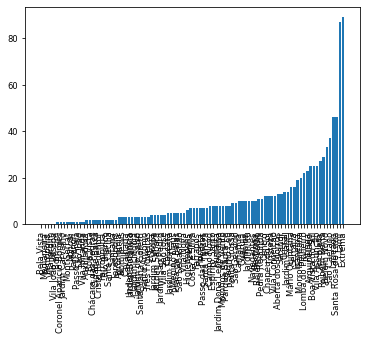

In [22]:
# Print results
sorted_districts = sorted(district_names, key=lambda x: wins[x])
for i,district in enumerate(sorted_districts[::-1]):
    print(f'#{i+1}\t| {district} has won {wins[district]} wars ({int(100*wins[district]/simulations)}% total)')
#end

# Plot histogram
plt.bar(sorted_districts, [wins[x] for x in sorted_districts])
plt.xticks(rotation='vertical')
plt.tick_params(labelsize='small')
plt.show()